In [256]:
import itertools

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math
import re

In [512]:
class Customer:
    def __init__(self, number, x, y, demand, readyTime, dueDate, serviceTime):
        self.number = number
        self.x = x
        self.y = y
        self.demand = demand
        self.readyTime = readyTime
        self.dueDate = dueDate
        self.serviceTime = serviceTime
        self.isVisited = False
        self.clusterLabel = 0

    def distance(self, point: Customer):
        return math.sqrt(math.pow(self.x - point.x, 2) + math.pow(self.y - point.y, 2))
    
class Problem:
    def __init__(self, name, customers: list, vehicleNumber, vehicleCapacity):
        self.name = name
        self.customers = customers
        self.vehicleNumber = vehicleNumber
        self.vehicleCapacity = vehicleCapacity
        self.depot: Customer = [x for x in customers if (x.number == 0)][0]
        self.depot.isVisited = True
        
    def getAvaliable(self):
        return [x for x in self.customers[1:] if x.isVisited == False]
    
    def getNearest(self, currentCustomer, avaliables, currentTime):
        
        info = []
        for customer in avaliables:
            info.append([round(current.distance(customer),8), customer.readyTime, customer.dueDate])
        if(len(info)==0):
            return self.depot
        minimum = np.finfo(np.float32).max
        for i in info:
            if(i[1]<=currentTime + i[0] and i[2] >=currentTime + i[0]):
                minimum = round(min(minimum, i[0]),8)
        ind = 0
        for i in range(len(info)):
            if(info[i][0] == minimum):
                ind = i
                break
        return avaliables[ind]
    
    def getCluster(self, clusterIndex):
        return [x for x in self.customers if x.clusterLabel == clusterIndex]
    
    def objectiveFunction(self, routes):
        sum = 0
        for route in routes:
            sum += route.total_distance()
        return sum

In [513]:
def readData(fileName) -> Problem:
        with open(fileName, 'r') as f:
            lines = list(map(lambda l: l.replace('\n', '').split(), f.readlines()))
        name = lines[0][0]
        vehicle_number, vehicle_capacity = list(map(int, lines[4]))
        customers = []
        for line in lines[9:]:
            customers.append(Customer(*list(map(int, line))))
        return Problem(name, customers, vehicle_number, vehicle_capacity)

In [547]:
class Route:
    def __init__(self, problem: Problem, customers: list):
        self.problem: Problem = problem
        self._customers: list = [self.problem.depot, *customers, self.problem.depot]
    @property
    def getRouteCustomers(self):
        return " ".join(str(customer.number) for customer in self._customers)

    def prePrintView(self):
        time = 0
        result = [0, 0.0]
        for source, target in zip(self._customers, self._customers[1:]):
            start_time = max([target.readyTime, time + source.distance(target)])
            time = start_time + target.serviceTime
            result.append(target.number)
            result.append(start_time)
        return " ".join(str(x) for x in result)

    def customers(self):
        return self._customers[1:-1]
    
    def allRouteCustomers(self):
        return self._customers

    def total_distance(self):
        return sum(a.distance(b) for (a, b) in zip(self._customers, self._customers[1:]))

    def is_feasible(self):
        time = 0
        capacity = self.problem.vehicleCapacity
        for source, target in zip(self._customers, self._customers[1:]):
            time = max([target.readyTime, time + source.distance(target)]) + target.serviceTime
            capacity -= target.demand
        return time <= self.problem.depot.dueDate and capacity >= 0

In [515]:
problem = readData("D://C266.txt")
problem

In [516]:
print(problem.vehicleNumber, problem.vehicleCapacity, math.ceil(averageCars))

150 700 10


In [517]:
coords = np.column_stack([[c.x for c in problem.customers[1:] ], [ c.y for c in problem.customers[1:] ]])
kmeans = KMeans( n_clusters = math.ceil(averageCars), random_state=0).fit(coords)
for i in range(len(kmeans.labels_)):
    problem.customers[i+1].clusterLabel = kmeans.labels_[i]

In [518]:
def plot_cluster(x, labels, colors_count):

    plt.scatter(x[:, 0], x[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", colors_count))
    plt.colorbar(ticks=range(colors_count))
    iter = 1
    for point in x:
        plt.text(point[0], point[1], iter)
        iter +=1
    plt.show()

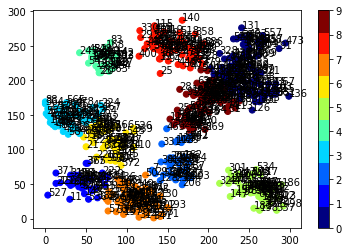

In [519]:
plot_cluster(coords, kmeans.labels_, np.max(kmeans.labels_)+1)

In [520]:
sums = [0 for i in range(0,math.ceil(averageCars))]
for x in problem.customers[1:]:    
    sums[x.clusterLabel] += x.demand

In [535]:
def getStartSolution(problem):
    averageCars = np.sum([x.demand for x in problem.customers])/int(problem.vehicleCapacity)
    coords = np.column_stack([[c.x for c in problem.customers[1:] ], [ c.y for c in problem.customers[1:] ]])
    
    kmeans = KMeans( n_clusters = math.ceil(averageCars), random_state=0).fit(coords)
    for i in range(len(kmeans.labels_)):
        problem.customers[i+1].clusterLabel = kmeans.labels_[i]
        
    sums = [0 for i in range(0,math.ceil(averageCars))]
    for x in problem.customers[1:]:    
        sums[x.clusterLabel] += x.demand
        
    routes = []
    route = []
    costs = 0

    while len(problem.getAvaliable()) >0:
        route.clear()
        weight = 0 
        current = problem.getAvaliable()[0]
        nearest = problem.getCluster(current.clusterLabel)
        current = problem.getNearest(problem.depot, nearest, costs)
        costs += current.distance(problem.depot)
        costs += current.serviceTime
        route.append(current)
        problem.customers[problem.customers.index(current)].isVisited = True
        nearest.remove(current)
        weight += current.demand
        last = current
        if(len(problem.getAvaliable()) >0):
            while len(nearest)>0:
                neighbor = problem.getNearest(last, nearest, costs)
                if(weight == problem.vehicleCapacity or weight + neighbor.demand > problem.vehicleCapacity):
                    nearest.clear();
                else:
                    if(neighbor in problem.getAvaliable()):
                        weight += neighbor.demand
                        costs += last.distance(neighbor)
                        costs += neighbor.serviceTime
                        route.append(neighbor)                 
                        problem.customers[problem.customers.index(neighbor)].isVisited = True
                        last = neighbor
                    nearest.remove(neighbor)
        if(weight< problem.vehicleCapacity and sums[current.clusterLabel]>weight):
            avs = problem.getAvaliable()
            while weight<= problem.vehicleCapacity or len(avs)>0:
                neighbor = problem.getNearest(last, avs, costs)
                if( neighbor.number == problem.depot.number):
                    break
                if(weight + neighbor.demand<= problem.vehicleCapacity):
                    weight += neighbor.demand
                    costs += neighbor.distance(last)
                    costs += neighbor.serviceTime
                    route.append(neighbor)
                    problem.customers[problem.customers.index(neighbor)].isVisited = True
                    last = neighbor
                avs.remove(neighbor)
        costs += problem.depot.distance(last)
        routes.append(Route(problem, route))
    return routes

In [524]:
def plotRoutes(routes):
    for route in routes:
        coordsX = []
        coordsY = []
        for customer in route.allRouteCustomers():
            coordsX.append(customer.x)
            coordsY.append(customer.y)
            plt.text(customer.x, customer.y, customer.number)
        plt.plot(coordsX, coordsY)
    plt.show()

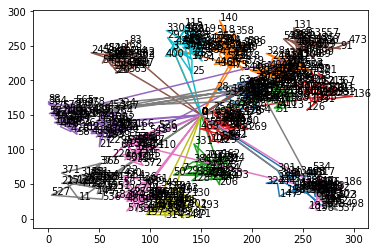

In [525]:
plotRoutes(routes)

*Local Search*

In [526]:
def two_opt(a, i, j):
    if i == 0:
        return a[j:i:-1] + [a[i]] + a[j + 1:]
    return a[:i] + a[j:i - 1:-1] + a[j + 1:]


def cross(a, b, i, j):
    return a[:i] + b[j:], b[:j] + a[i:]


def insertion(a, b, i, j):
    if len(a) == 0:
        return a, b
    while i >= len(a):
        i -= len(a)
    return a[:i] + a[i + 1:], b[:j] + [a[i]] + b[j:]


def swap(a, b, i, j):
    if i >= len(a) or j >= len(b):
        return a, b
    a, b = a.copy(), b.copy()
    a[i], b[j] = b[j], a[i]
    return a, b

In [527]:
class LocalSearch:
    def __init__(self, problem: Problem):
        self.problem: Problem = problem

    def optimize(self, routes: list) -> list:
        newRoutes = list(routes)
        for i in range(len(newRoutes)):
            stopped = False
            while not stopped:
                route = newRoutes[i]
                stopped = True
                for k, j in itertools.combinations(range(len(route.customers())), 2):
                    newRoute = Route(self.problem, two_opt(route.customers(), k, j))
                    if newRoute.is_feasible:
                        if newRoute.total_distance() < route.total_distance():
                            newRoutes[i] = newRoute
                            stopped = False
        return newRoutes


In [528]:
class IteratedLocalSearch(LocalSearch):
    def __init__(self, problem: Problem, objectiveFunction=None):
        super().__init__(problem)
        if not objectiveFunction:
            objectiveFunction = self.problem.objectiveFunction
        self.objectiveFunction = objectiveFunction
        self.initial_solution = getStartSolution(problem)

    def perturbation(self, routes: list) -> list:
        best = [Route(self.problem, route.customers()) for route in routes]
        stopped = False
        while not stopped:
            stopped = True
            # Для всех возможных пар маршрутов
            for i, j in itertools.combinations(range(len(best)), 2):
                # Для всех возможных индексов в двух маршрутах
                for k, l in itertools.product(range(len(best[i].customers()) + 2), range(len(best[j].customers()) + 2)):
                    for func in [cross, insertion]:
                        c1, c2 = func(best[i].customers(), best[j].customers(), k, l)
                        r1, r2 = Route(self.problem, c1), Route(self.problem, c2)
                        if r1.is_feasible() and r2.is_feasible():
                            if r1.total_distance() + r2.total_distance() < best[i].total_distance() + best[j].total_distance():
                                best[i] = r1
                                best[j] = r2
                                stopped = False
            best = list(filter(lambda x: len(x.customers()) != 0, best))
        return best

    def execute(self):
        best = self.optimize(self.initial_solution)
        
        stopped = False
        while not stopped:
            stopped = True
            newRoutes = self.perturbation(best)
            newRoutes = self.optimize(newRoutes)
            if self.objectiveFunction(newRoutes) < self.objectiveFunction(best):
                stopped = False
                best = list(filter(lambda x: len(x.customers()) != 0, newRoutes))
            else:
                print(self.objectiveFunction(newRoutes),self.objectiveFunction(best))
        return best


In [572]:
problem = readData("D://dt//C203.txt")
problem

In [550]:
ils = IteratedLocalSearch(problem)

In [551]:
bestRoutes = ils.execute()

830.0144255688224 830.0144255688224


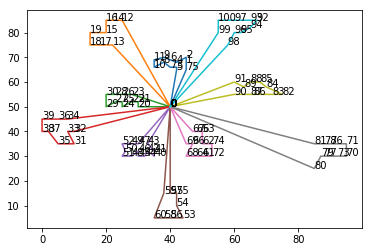

In [552]:
plotRoutes(bestRoutes)

In [553]:
def sumRoutes(routes):
    sum = 0
    for route in routes:
        sum += route.total_distance()
    return sum

In [554]:
sumRoutes(bestRoutes)

830.0144255688224

In [560]:
def writeResults(problem, routes):
    f = open(problem.name + ".sol", "w")
    for route in routes:
        f.write(route.prePrintView()+"\n")

In [561]:
writeResults(problem, bestRoutes)

In [563]:
import sys
import os

In [579]:
def prepareData(walk_dir):
    for root, subdirs, files in os.walk(walk_dir):
        for filename in files:
            print(root + filename)
            problem = readData(root + filename)
            ils = IteratedLocalSearch(problem)
            bestRoutes = ils.execute()
            writeResults(problem, bestRoutes)

In [ ]:
prepareData("D://dt//")

D://dt//C203.txt
615.7779563401563 615.7779563401563
D://dt//C249.TXT
4385.908767607318 4385.908767607318
D://dt//C266.TXT
